# Introduction to Autograd
Automatic Differentiation, or autograd, is a technique used to compute the derivative of functions defined by computer programs. Unlike symbolic differentiation (which finds a general formula for the derivative) or numerical differentiation (which approximates the derivative), autograd calculates the exact numerical value of the derivative at a specific point by breaking down complex functions into a series of elementary operations and applying the chain rule.

## Why is Autograd Important?

In the context of machine learning, autograd is fundamental for training models, especially neural networks. Training typically involves minimizing a loss function, which measures how well the model's predictions match the actual data. Optimization algorithms like gradient descent require the gradients (derivatives) of the loss function with respect to the model's parameters. These gradients indicate the direction and magnitude of change needed for each parameter to reduce the loss.
Autograd efficiently calculates these gradients, even for models with millions of parameters and complex architectures. It does this by building a computational graph during the forward pass (when the model makes predictions) and then performing a backward pass to compute the gradients. This process is significantly more efficient and accurate than manual differentiation or numerical approximations for complex models.


## The `Value` Class: The Building Block of Autograd
At the core of this autograd system is the `Value` class. Each `Value` object represents a single scalar value and is designed to track the operations performed on it, allowing us to compute gradients automatically.
### Key Components of the `Value` Class
Think of a `Value` object as a node in a computational graph. It holds:
- **`data`**: The numerical value of the scalar.
- **`grad`**: The gradient of the final output with respect to this value. This is initialized to 0 and accumulates during the backward pass.
- **`_prev`**: A set of parent nodes (other `Value` objects) that were used to compute this value.
- **`_op`**: The operation that produced this value (e.g., addition, multiplication).
The `Value` class will also store information about how it was created (the operation and its parent `Value` objects) to reconstruct the computational graph during backpropagation.

In [ ]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

## Core Logic of Autograd
### Downstream Gradient Calculation
The core logic of autograd can be summarized as follows:
\[ \text{downstream grad} = \text{local grad} \times \text{upstream grad} \]
This formula is the essence of the chain rule in calculus, applied to computational graphs. Here's what each term means:
- **Local Gradient**: The derivative of the current node's output with respect to its input(s).
- **Upstream Gradient**: The gradient flowing into the current node from the output of the graph.
- **Downstream Gradient**: The gradient flowing out of the current node to its input(s).
By multiplying the local gradient with the upstream gradient, we propagate the gradient backward through the computational graph.


## Adding Basic Operations (`+`, `*`, `pow`)
The `Value` class is designed to build a computational graph by tracking the relationships between values through arithmetic operations. This is crucial for backpropagation, where we traverse the graph backward to compute gradients.
### How Basic Operations Work
- **Addition (`__add__`)**: When two `Value` objects (or a `Value` and a scalar) are added, a new `Value` object is created. This new object stores the sum of the data from the operands and keeps track of the operands as its children (`_prev`). The `_op` attribute is set to '+'.
- **Multiplication (`__mul__`)**: Similar to addition, multiplication of `Value` objects creates a new `Value` object representing the product. The operands are stored as children, and `_op` is set to '*'.
- **Exponentiation (`__pow__`)**: This method handles raising a `Value` object to a scalar power. A new `Value` object stores the result, and the base (`self`) is kept as a child. The `_op` indicates the power.
These methods not only perform the forward pass calculation but also establish the connections in the computational graph and define the local gradients needed for the backward pass.

# Forward Pass

In [ ]:
import math

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        return out

    def __repr__(self):
        return f"Value(data={self.data}, operation={self._op}, children={self._prev})"

In [ ]:
x = Value(1.0)
y = Value(2.0)
z = x.__add__(y)

print(z)

Value(data=3.0, operation=+, children={Value(data=1.0, operation=, children=set()), Value(data=2.0, operation=, children=set())})


In [ ]:
x = Value(1.0)
y = Value(2.0)
z = x + y

print(z)

Value(data=3.0, operation=+, children={Value(data=2.0, operation=, children=set()), Value(data=1.0, operation=, children=set())})


In [ ]:
import math

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        return out

    def __repr__(self):
        return f"Value(data={self.data}, operation={self._op}, children={self._prev})"

In [ ]:
x = Value(2.0)
y = Value(-3.0)
mul = x*y
b = Value(10.0)

L = mul + b

print(x)
print(y)
print(mul)
print(b)
print(L)

Value(data=2.0, operation=, children=set())
Value(data=-3.0, operation=, children=set())
Value(data=-6.0, operation=*, children={Value(data=2.0, operation=, children=set()), Value(data=-3.0, operation=, children=set())})
Value(data=10.0, operation=, children=set())
Value(data=4.0, operation=+, children={Value(data=10.0, operation=, children=set()), Value(data=-6.0, operation=*, children={Value(data=2.0, operation=, children=set()), Value(data=-3.0, operation=, children=set())})})


In [ ]:
import math

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
x = Value(2.0)
y = Value(-3.0)
mul = x*y
b = Value(10.0)

L = mul + b
L.grad = 1.0

L._backward()

mul._backward()

print(x)
print(y)
print(mul)
print(b)
print(L)

Value(data=2.0, grad=-3.0)
Value(data=-3.0, grad=2.0)
Value(data=-6.0, grad=1.0)
Value(data=10.0, grad=1.0)
Value(data=4.0, grad=1.0)


## Implementing `backward`
Backpropagation is the algorithm used to compute gradients of the loss function with respect to the model's parameters in a neural network. It works by applying the chain rule of calculus in reverse, starting from the output of the computational graph and moving towards the inputs.
### Steps in Backpropagation
1. **Initialize the Gradient**: The gradient of the output node (the node on which `backward()` is called) is set to 1, as the gradient of a variable with respect to itself is 1.
2. **Topological Sorting**: Perform a topological sort of the computational graph starting from the output node. This ensures that when we compute the gradient for a node, the gradients of all nodes that depend on it (its children in the graph) have already been computed.
3. **Apply the Chain Rule**: Iterate through the nodes in reverse topological order. For each node, call its `_backward` method. This method accumulates the gradient from the node's children and distributes it to the node's parents according to the chain rule.

In [ ]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
x = Value(2.0)
y = Value(-3.0)
mul = x*y
b = Value(10.0)

L = mul + b
L.backward()

print(x)
print(y)
print(mul)
print(b)
print(L)

Value(data=2.0, grad=-3.0)
Value(data=-3.0, grad=2.0)
Value(data=-6.0, grad=1)
Value(data=10.0, grad=1)
Value(data=4.0, grad=1)


## Visualization with `draw_dot`
Understanding the flow of computation and how gradients are calculated is crucial in automatic differentiation. The `draw_dot` function helps visualize this process by rendering the computational graph.
### How `draw_dot` Works
1. **Trace the Graph**: The `trace` function recursively traverses the `_prev` attributes of the `Value` objects, starting from the output node. This identifies all the nodes and edges in the graph.
2. **Render the Graph**: The `draw_dot` function uses the `graphviz` library to generate a visual representation of the graph. Each `Value` object is represented as a node, and edges represent dependencies between nodes.

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

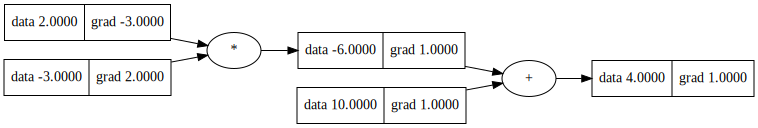

In [ ]:
x = Value(2.0)
y = Value(-3.0)
mul = x*y
b = Value(10.0)

L = mul + b
L.backward()

draw_dot(L)

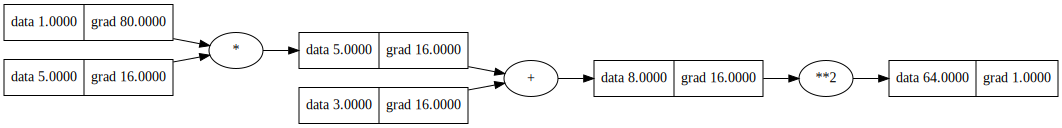

In [ ]:
w = Value(5.0)
x = Value(1.0)
c = w*x + 3
d = c**2

d.backward()
draw_dot(d)

### Analogy with Tensors

In [ ]:
import torch

# Define tensors which requires_grad=True
x = torch.tensor(2.0, requires_grad=False)
w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# Perform a forward pass and calculate the loss
y = w * x + b
loss = y**2

# This computes d(loss)/dx and d(loss)/db
loss.backward()

# The gradient is accumulated into the .grad attribute
print(f"Gradient of loss with respect to x: {x.grad}")
print(f"Gradient of loss with respect to w: {w.grad}")
print(f"Gradient of loss with respect to b: {b.grad}")

Gradient of loss with respect to x: None
Gradient of loss with respect to w: 28.0
Gradient of loss with respect to b: 14.0


In [ ]:
learning_rate = 0.01

# GD Update Rule
with torch.no_grad():
    w.data -= learning_rate * w.grad
    b.data -= learning_rate * b.grad

# Updated Gradients
print(f"Updated w: {w.data}")
print(f"Updated b: {b.data}")

# Zero the gradients for the next iteration
w.grad.zero_()
b.grad.zero_()

# Verify gradients are now zero
print(f"Gradient of w after zero_(): {w.grad}")
print(f"Gradient of b after zero_(): {b.grad}")

Updated w: 2.7200000286102295
Updated b: 0.8600000143051147
Gradient of w after zero_(): 0.0
Gradient of b after zero_(): 0.0


## Handling More Complex Operations and Sigmoid
To make our `Value` class more versatile, we need to implement additional operations beyond basic addition, multiplication, and exponentiation. We can leverage the operations we've already defined to build these new functionalities.


### Negation (`__neg__`)
Negation, or taking the negative of a `Value` (e.g., `-a`), can be implemented as multiplication by -1.

If `c = -a`, then `c = a * -1`.

The derivative $\frac{dc}{da}$ is simply the derivative of $a \cdot -1$ with respect to $a$, which is $-1$. Using the chain rule, $\frac{dL}{da} = \frac{dL}{dc} \cdot \frac{dc}{da} = \frac{dL}{dc} \cdot -1$.

In our `_backward` method for negation (which is handled by the multiplication's `_backward`), if `out = self * -1`, then `self.grad += -1 * out.grad`.

---

### Subtraction (`__sub__`, `__rsub__`)
Subtraction (e.g., `a - b`) can be defined in terms of addition and negation: `a - b = a + (-b)`. This allows us to reuse the `__add__` and `__neg__` methods and their respective `_backward` implementations.

For $c = a - b = a + (-b)$, the chain rule applies:
- $\frac{dL}{da} = \frac{dL}{dc} \cdot \frac{dc}{da}$. Since $\frac{dc}{da}$ for $a + (-b)$ is $1$ (treating $-b$ as a constant with respect to $a$), $\frac{dL}{da} = \frac{dL}{dc} \cdot 1$.
- $\frac{dL}{db} = \frac{dL}{dc} \cdot \frac{dc}{db}$. Since $\frac{dc}{db}$ for $a + (-b)$ is the derivative of $a + u$ with respect to $b$, where $u = -b$:
    - By the chain rule, $\frac{dL}{db} = \frac{dL}{du} \cdot \frac{du}{db}$.
    - $\frac{dL}{du} = \frac{dL}{dc} \cdot \frac{dc}{du} = \frac{dL}{dc} \cdot 1$.
    - $\frac{du}{db}$ is the derivative of $-b$ with respect to $b$, which is $-1$.
    - So, $\frac{dL}{db} = \frac{dL}{dc} \cdot 1 \cdot -1 = -\frac{dL}{dc}$.

Our `_backward` methods for addition and negation handle this automatically.

We also need `__rsub__` for cases like `5 - a`, which allows the left operand (an integer or float) to be handled correctly by calling `a.__rsub__(5)`, which we define as `other + (-self)`.

---

### Division (`__truediv__`, `__rtruediv__`)
Division (e.g., `a / b`) can be defined in terms of multiplication and exponentiation: `a / b = a * (b**-1)`. This allows us to reuse the `__mul__` and `__pow__` methods and their `_backward` implementations.

For $c = a / b = a \cdot (b^{-1})$, the chain rule applies:
- $\frac{dL}{da} = \frac{dL}{dc} \cdot \frac{dc}{da}$. Since $\frac{dc}{da}$ for $a \cdot (b^{-1})$ is $b^{-1}$ (treating $b^{-1}$ as a constant with respect to $a$), $\frac{dL}{da} = \frac{dL}{dc} \cdot (b^{-1})$.
- $\frac{dL}{db} = \frac{dL}{dc} \cdot \frac{dc}{db}$. Since $\frac{dc}{db}$ for $a \cdot (b^{-1})$ is the derivative of $a \cdot u$ with respect to $b$, where $u = b^{-1}$:
    - By the chain rule, $\frac{dL}{db} = \frac{dL}{du} \cdot \frac{du}{db}$.
    - $\frac{dL}{du} = \frac{dL}{dc} \cdot \frac{dc}{du} = \frac{dL}{dc} \cdot a$.
    - $\frac{du}{db}$ is the derivative of $b^{-1}$ with respect to $b$, which is $-1 \cdot b^{-2}$.
    - So, the full derivative is:
      $$\frac{dL}{db} = \frac{dL}{dc} \cdot a \cdot (-1 \cdot b^{-2}) = -\frac{dL}{dc} \cdot a \cdot b^{-2} = -\frac{dL}{dc} \cdot \frac{a}{b^2}$$
Again, our `_backward` methods for multiplication and power handle this compositionally.

We also need `__rtruediv__` for cases like `5 / a`, which allows the left operand to be handled correctly by calling `a.__rtruediv__(5)`, which we define as `other * self**-1`.

---

### Sigmoid Function (`sigmoid`)
The sigmoid function is a common activation function in neural networks, defined as:
$$s(x) = \frac{1}{1 + \exp(-x)}$$
The derivative of the sigmoid function with respect to its input $x$ has a simple form:
$$\frac{ds}{dx} = s(x) \cdot (1 - s(x))$$
If `out = self.sigmoid()`, then $\text{out.data} = \frac{1}{1 + \exp(-\text{self.data})}$.

Using the chain rule, $\frac{dL}{d(\text{self})} = \frac{dL}{d(\text{out})} \cdot \frac{d(\text{out})}{d(\text{self})}$.

The local derivative $\frac{d(\text{out})}{d(\text{self})}$ is the derivative of the sigmoid function evaluated at `self.data`.

So, $\frac{dL}{d(\text{self})} = \frac{dL}{d(\text{out})} \cdot \text{out.data} \cdot (1 - \text{out.data})$.

Our `_backward` method for `sigmoid` directly implements this: `self.grad += out.grad * (out.data * (1 - out.data))`.

In [ ]:
import math

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def sigmoid(self):
        s = 1 / (1 + math.exp(-self.data))
        out = Value(s, (self,), 'sigmoid')

        def _backward():
            # The local derivative of sigmoid is s * (1 - s)
            self.grad += (out.data * (1 - out.data)) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1



    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

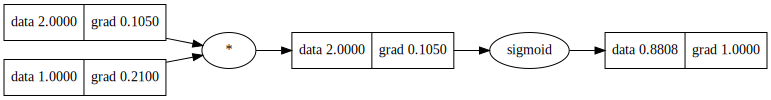

In [ ]:
a = Value(1.0)
b = 2*a
c = b.sigmoid()

c.backward()
draw_dot(c)

## Putting it all together

### Tutorial Summary

So far in this tutorial, we have built the foundational elements for automatic differentiation:

-   The `Value` class: A wrapper around a scalar value that also stores its gradient and a reference to the operation that created it, allowing for the construction of a computational graph.
-   Basic and Complex Operations: We've implemented methods (`__add__`, `__mul__`, `__pow__`, `__neg__`, `__sub__`, `__truediv__`) that overload Python's operators to work with `Value` objects and automatically build the computational graph by tracking dependencies. We also added the `sigmoid` activation function.
-   The `backward` Method: This method performs backpropagation. It uses a topological sort of the computational graph to ensure gradients are computed in the correct order, applying the chain rule by calling the `_backward` method of each `Value` object.
-   The `draw_dot` Function: This utility helps visualize the computational graph generated by our `Value` objects and operations, including the data and gradient values at each node.

Now, let's put these pieces together with a more complex example. The following code cell will define a computation involving multiple `Value` objects and a variety of the operations we've implemented. We will then perform backpropagation on the final result to compute the gradients throughout the graph and visualize this complex graph with `draw_dot` to see the flow and the calculated gradients.python


Final value (v.data): 4.6945
Gradient of x (x.grad): 24.7180
Gradient of y (y.grad): 106.6648


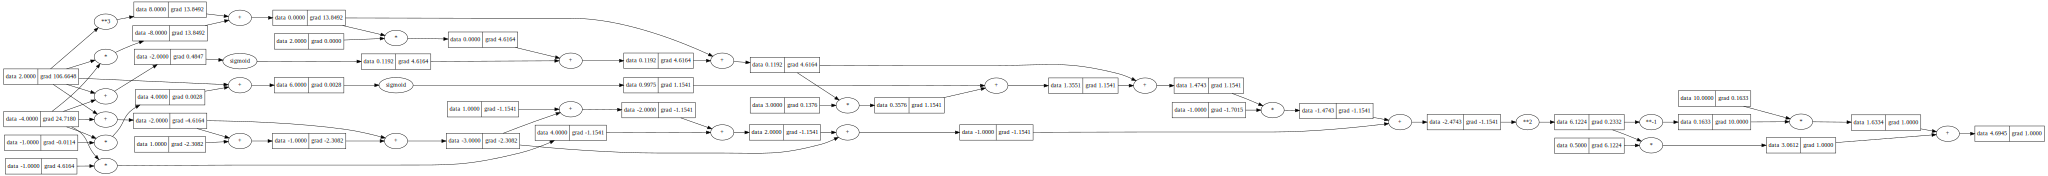

In [ ]:
# Complex Example with Backpropagation and Visualization

# Define initial Value objects
x = Value(-4.0)
y = Value(2.0)

# Perform a series of complex operations
q = x + y
r = x * y + y**3
q += q + 1
q += 1 + q + (-x)
r += r * 2 + (y + x).sigmoid()
r += 3 * r + (y - x).sigmoid()
s = q - r
t = s**2
u = t / 2.0
v = u + 10.0 / t

# Print the final value
print(f'Final value (v.data): {v.data:.4f}')

# Perform backpropagation
v.backward()

# Print gradients of initial values
print(f'Gradient of x (x.grad): {x.grad:.4f}')
print(f'Gradient of y (y.grad): {y.grad:.4f}')

# Visualize the computational graph
draw_dot(v)